In [ ]:
#Assuming all necessary libraries and datasets are loaded

#Dataloaders with librispeech dataset
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

Define AudioNet Base structure

In [ ]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Training function and training commands

In [ ]:

subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()
# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
output_size = len(np.unique(speaker_mfcc_db['speaker_id']))

net =  CustomNet(num_classes=output_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
#Train
trained_model, history = train_and_validate(net, epochs=10, batch_size = 64, lr=1e-4)

Epoch: 1/10


C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 2.7241, Accuracy: 43.5812%, 
		Validation : Loss : 0.7397, Accuracy: 80.0093%, Time: 440.8508s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.6044, Accuracy: 82.9548%, 
		Validation : Loss : 0.4025, Accuracy: 88.8361%, Time: 441.8106s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.3399, Accuracy: 89.9637%, 
		Validation : Loss : 0.4047, Accuracy: 89.0672%, Time: 444.2392s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.2364, Accuracy: 92.7554%, 
		Validation : Loss : 0.2605, Accuracy: 92.9149%, Time: 446.9260s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.1812, Accuracy: 94.3254%, 
		Validation : Loss : 0.1961, Accuracy: 94.6224%, Time: 440.2298s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.1451, Accuracy: 95.3719%, 
		Validation : Loss : 0.2367, Accuracy: 93.9599%, Time: 443.3254s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.1225, Accuracy: 96.0975%, 
		Validation : Loss : 0.2150, Accuracy: 94.7066%, Time: 443.3344s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.1055, Accuracy: 9

Plot Train/Loss Curve

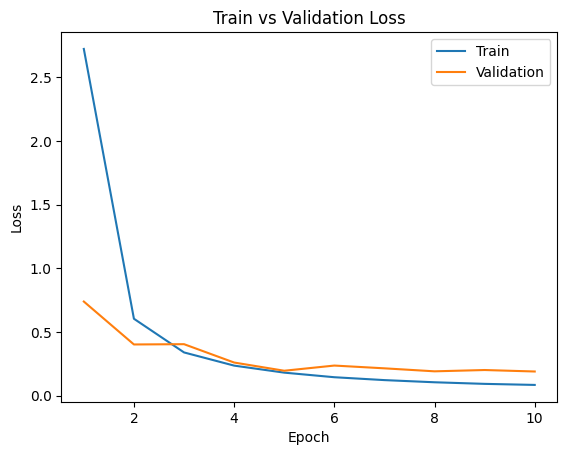

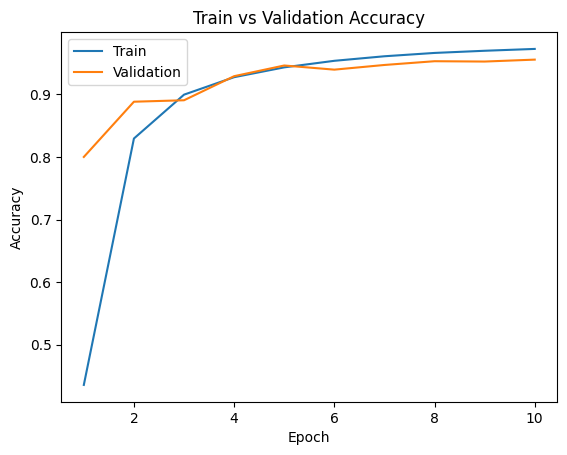

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Testing function and accuracy for AudioNet on Librispeech test dataset

In [ ]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')



In [ ]:
test_model(net, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 95 %


In [ ]:
#Saving the trained model

path = r"F:\speaker_project\audio-speaker-recognition\notebooks\net.pth"
torch.save(net, path)

Transfer Learning with VoxCeleb dataset

In [ ]:
#Re-call empty AudioNet Structure
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
'''
Load the pretrained  Model
'''
#Copy the full path of net.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\net.pth')

In [ ]:
#Modify the last layer to number of celebs (classes) in new dataset
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(2048, 1252)

model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

Train the transfer learnt model

In [ ]:
net =  model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

trained_model, history = train_and_validate(net, epochs=12, batch_size = 32, lr=1e-4)

Epoch: 1/12


C:\Users\David\AppData\Local\Temp\ipykernel_5824\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 3.8310, Accuracy: 36.2377%, 
		Validation : Loss : 2.6017, Accuracy: 52.3708%, Time: 222.7289s
Epoch: 2/12
Epoch : 002, Training: Loss: 2.1073, Accuracy: 55.1573%, 
		Validation : Loss : 2.2174, Accuracy: 59.0938%, Time: 221.2566s
Epoch: 3/12
Epoch : 003, Training: Loss: 1.6570, Accuracy: 62.1181%, 
		Validation : Loss : 2.0948, Accuracy: 61.9908%, Time: 221.5474s
Epoch: 4/12
Epoch : 004, Training: Loss: 1.4098, Accuracy: 66.4072%, 
		Validation : Loss : 2.0570, Accuracy: 63.4448%, Time: 209.7317s
Epoch: 5/12
Epoch : 005, Training: Loss: 1.2361, Accuracy: 69.3367%, 
		Validation : Loss : 2.0319, Accuracy: 64.5667%, Time: 209.1147s
Epoch: 6/12
Epoch : 006, Training: Loss: 1.1082, Accuracy: 71.7863%, 
		Validation : Loss : 2.0411, Accuracy: 65.1462%, Time: 213.6651s
Epoch: 7/12
Epoch : 007, Training: Loss: 1.0218, Accuracy: 73.4094%, 
		Validation : Loss : 2.0495, Accuracy: 65.8623%, Time: 226.2184s
Epoch: 8/12
Epoch : 008, Training: Loss: 0.9448, Accuracy: 7

Plot Train/Loss Curve

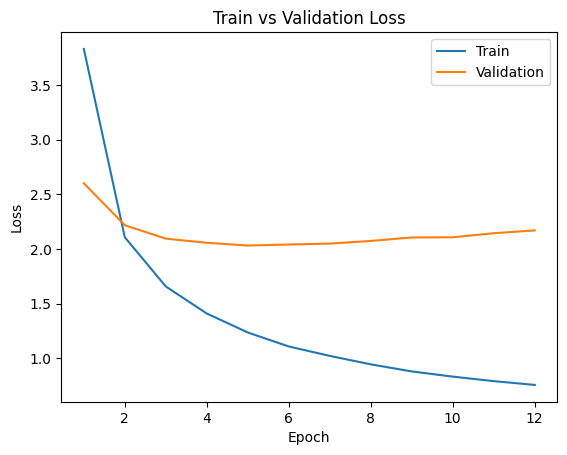

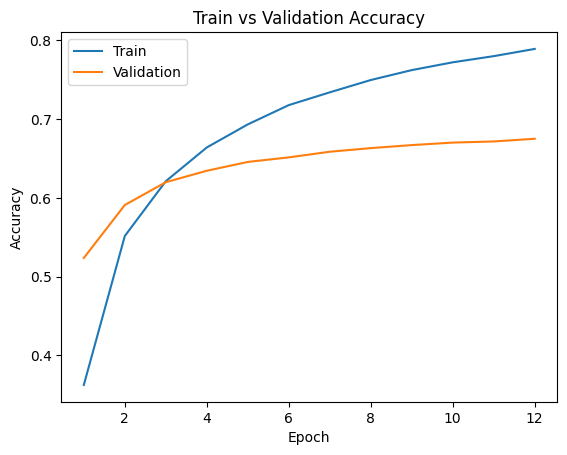

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [ ]:
#Test the transfer learning model on vox celeb test dataset
test_model(model, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_5824\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 67 %


In [ ]:
#Saving the transfer learning model on celeb+Sinisa dataset

path = r"F:\speaker_project\audio-speaker-recognition\notebooks\transferred_model.pth"
torch.save(model, path)

Demo

In [ ]:
'''
Load the pretrained Trasfer Learnt AudioNet Model
'''
#Copy the full path of net.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\transferred_model.pth')

In [ ]:
#Load the index-name file for voxceleb model
voxfile = r"F:\speaker_project\audio-speaker-recognition\notebooks\vox1_meta.csv"
vox_df = pd.read_csv(voxfile)

In [ ]:
#Creating a name list with its index and test run
name = []
for i in range(1251):

    name.append(str(vox_df.iloc[i])[64:].split('\\')[0])
name[1250]

'Zulay_Henao'

In [ ]:
#Demo helper functions
def print_name(speakers, predicted):
    actual = []
    model_output = []
    speakers.tolist()
    predicted.tolist()
    for spk in speakers:
        actual.append(name[spk-1])
    for pred in predicted:
        model_output.append(name[pred-1])


    dict = {"Actual":actual,"Predicted":model_output}
    return pd.DataFrame(dict)
    #print("Actual Celeberity in this demo batch are:", actual)
    #print("Model predictions are:", model_output)

def get_ith_batch_result(num):
    with torch.no_grad():
        cnt = 0
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            df = print_name(speakers, predicted)
            cnt += 1
            if cnt == num:
                break
    return df

In [ ]:
#Get the ith batch test_loader result comparision
result = get_ith_batch_result(240)
result

C:\Users\David\AppData\Local\Temp\ipykernel_2308\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


,Actual,Predicted
0,Eli_Wallach,Leslie_Mann
1,Izabella_Scorupco,Izabella_Scorupco
2,Cher,Cher
3,Brendan_Gleeson,Brendan_Gleeson
4,Mark_Sheppard,Mark_Sheppard
5,Rhys_Darby,Rhys_Darby
6,Michaela_Conlin,Michaela_Conlin
7,Monica_Raymund,Monica_Raymund
8,Hill_Harper,Sharlto_Copley
9,Brian_Cox,Brian_Cox
